<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Machine-Learning-with-Probabilistic-Programming" data-toc-modified-id="Final-Project-Machine-Learning-with-Probabilistic-Programming-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Final Project Machine Learning with Probabilistic Programming</a></span><ul class="toc-item"><li><span><a href="#Fall-2018,-Columbia-University,-New-York,-Prof.-Alp-Kucukelbir" data-toc-modified-id="Fall-2018,-Columbia-University,-New-York,-Prof.-Alp-Kucukelbir-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fall 2018, Columbia University, New York, Prof. Alp Kucukelbir</a></span><ul class="toc-item"><li><span><a href="#Jan-Felix-Schneider-(jfs2160),-Brian-Allen-(ba2542)" data-toc-modified-id="Jan-Felix-Schneider-(jfs2160),-Brian-Allen-(ba2542)-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Jan-Felix Schneider (jfs2160), Brian Allen (ba2542)</a></span></li></ul></li></ul></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Problem-Statement" data-toc-modified-id="Problem-Statement-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Problem Statement</a></span><ul class="toc-item"><li><span><a href="#Given-Empty-Graph" data-toc-modified-id="Given-Empty-Graph-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Given Empty Graph</a></span></li><li><span><a href="#Observe-Set-of-Cascades" data-toc-modified-id="Observe-Set-of-Cascades-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Observe Set of Cascades</a></span></li><li><span><a href="#Infer-Network-Structure" data-toc-modified-id="Infer-Network-Structure-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Infer Network Structure</a></span></li></ul></li></ul></li><li><span><a href="#Models" data-toc-modified-id="Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#Model-1" data-toc-modified-id="Model-1-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Model 1</a></span><ul class="toc-item"><li><span><a href="#Transmission-Parameters" data-toc-modified-id="Transmission-Parameters-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Transmission Parameters</a></span></li><li><span><a href="#Cascade-Likelihood" data-toc-modified-id="Cascade-Likelihood-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Cascade Likelihood</a></span></li><li><span><a href="#Cascade-Seed" data-toc-modified-id="Cascade-Seed-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Cascade Seed</a></span></li><li><span><a href="#Generative-Model" data-toc-modified-id="Generative-Model-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Generative Model</a></span></li><li><span><a href="#Graphical-Model" data-toc-modified-id="Graphical-Model-3.1.5"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Graphical Model</a></span></li><li><span><a href="#Parameter-Estimation" data-toc-modified-id="Parameter-Estimation-3.1.6"><span class="toc-item-num">3.1.6&nbsp;&nbsp;</span>Parameter Estimation</a></span></li></ul></li><li><span><a href="#Model-2---Topics" data-toc-modified-id="Model-2---Topics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model 2 - Topics</a></span><ul class="toc-item"><li><span><a href="#Cascade-Topic-Assignment" data-toc-modified-id="Cascade-Topic-Assignment-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Cascade Topic Assignment</a></span></li><li><span><a href="#Transmission-Parameters" data-toc-modified-id="Transmission-Parameters-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Transmission Parameters</a></span></li><li><span><a href="#Generative-Model" data-toc-modified-id="Generative-Model-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Generative Model</a></span></li><li><span><a href="#Graphical-Model" data-toc-modified-id="Graphical-Model-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Graphical Model</a></span></li></ul></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Generated-Datasets-&lt;-PLACEHOLDER-&gt;" data-toc-modified-id="Generated-Datasets-<-PLACEHOLDER->-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Generated Datasets &lt; PLACEHOLDER &gt;</a></span></li><li><span><a href="#Memetracker-&lt;-PLACEHOLDER-&gt;" data-toc-modified-id="Memetracker-<-PLACEHOLDER->-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Memetracker &lt; PLACEHOLDER &gt;</a></span></li></ul></li><li><span><a href="#Model-1-Inference" data-toc-modified-id="Model-1-Inference-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model 1 Inference</a></span></li><li><span><a href="#Model-2-Inference" data-toc-modified-id="Model-2-Inference-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model 2 Inference</a></span></li><li><span><a href="#Model-1-Criticism" data-toc-modified-id="Model-1-Criticism-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Model 1 Criticism</a></span><ul class="toc-item"><li><span><a href="#Generated-Dataset-&lt;-PLACEHOLDER-&gt;" data-toc-modified-id="Generated-Dataset-<-PLACEHOLDER->-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Generated Dataset &lt; PLACEHOLDER &gt;</a></span></li><li><span><a href="#Memetracker" data-toc-modified-id="Memetracker-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Memetracker</a></span></li></ul></li><li><span><a href="#Model-2-Criticism" data-toc-modified-id="Model-2-Criticism-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model 2 Criticism</a></span></li><li><span><a href="#Issues-with-Edward" data-toc-modified-id="Issues-with-Edward-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Issues with Edward</a></span><ul class="toc-item"><li><span><a href="#What-we-tried-in-Edward" data-toc-modified-id="What-we-tried-in-Edward-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>What we tried in Edward</a></span></li><li><span><a href="#Non-Differentiability-of-Shortest-Path" data-toc-modified-id="Non-Differentiability-of-Shortest-Path-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Non-Differentiability of Shortest Path</a></span></li><li><span><a href="#Issues-with-Random-Variable-Class" data-toc-modified-id="Issues-with-Random-Variable-Class-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Issues with Random Variable Class</a></span></li></ul></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Future Work</a></span><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Modeling</a></span></li><li><span><a href="#Inference" data-toc-modified-id="Inference-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Inference</a></span></li><li><span><a href="#Criticism" data-toc-modified-id="Criticism-10.3"><span class="toc-item-num">10.3&nbsp;&nbsp;</span>Criticism</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#GRAVEYARD" data-toc-modified-id="GRAVEYARD-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>GRAVEYARD</a></span></li><li><span><a href="#Load-Modules" data-toc-modified-id="Load-Modules-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Load Modules</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#Model-1-Inference" data-toc-modified-id="Model-1-Inference-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>Model 1 Inference</a></span></li><li><span><a href="#Model-1-Criticism" data-toc-modified-id="Model-1-Criticism-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Model 1 Criticism</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Implementing-the-prior-probability-in-TF" data-toc-modified-id="Implementing-the-prior-probability-in-TF-16.0.1"><span class="toc-item-num">16.0.1&nbsp;&nbsp;</span>Implementing the prior probability in TF</a></span></li></ul></li></ul></li><li><span><a href="#Inference" data-toc-modified-id="Inference-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Inference</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Using-edward-Inference" data-toc-modified-id="Using-edward-Inference-17.0.1"><span class="toc-item-num">17.0.1&nbsp;&nbsp;</span>Using edward Inference</a></span></li><li><span><a href="#Using-BFGS-to-obtain-MAP-estimates" data-toc-modified-id="Using-BFGS-to-obtain-MAP-estimates-17.0.2"><span class="toc-item-num">17.0.2&nbsp;&nbsp;</span>Using BFGS to obtain MAP estimates</a></span></li></ul></li></ul></li><li><span><a href="#Criticism" data-toc-modified-id="Criticism-18"><span class="toc-item-num">18&nbsp;&nbsp;</span>Criticism</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Predictions" data-toc-modified-id="Predictions-18.0.1"><span class="toc-item-num">18.0.1&nbsp;&nbsp;</span>Predictions</a></span></li><li><span><a href="#Compare-to-&quot;influence-approximations&quot;" data-toc-modified-id="Compare-to-&quot;influence-approximations&quot;-18.0.2"><span class="toc-item-num">18.0.2&nbsp;&nbsp;</span>Compare to "influence approximations"</a></span></li><li><span><a href="#Visualizing-MAP-Estimate-Results" data-toc-modified-id="Visualizing-MAP-Estimate-Results-18.0.3"><span class="toc-item-num">18.0.3&nbsp;&nbsp;</span>Visualizing MAP Estimate Results</a></span></li></ul></li></ul></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-19"><span class="toc-item-num">19&nbsp;&nbsp;</span>Future Work</a></span></li></ul></div>

In [27]:
from hdiffnet.utils import * 
from hdiffnet.cascade_generator import GenerativeModel
import matplotlib.pyplot as plt

In [29]:
alpha = np.array([[0, .1, 0, 0, 0, .2, 0, 0, 0, 0],
                  [0, 0, .5, 0, 0, 0, 0, .25, 0, 0],
                  [0, 0, 0, .4, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, .5, 0, 0, .1, 0, 0],
                  [0, 0, 0, 0, 0, .3, 0, 0, .2, 0],
                  [0, 0, 0, 0, 0, 0, .7, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, .6, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, .3],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)

nx_graph, nx_layout, nx_weights, nx_labels = buildGraph(alpha)

# Final Project Machine Learning with Probabilistic Programming 
## Fall 2018, Columbia University, New York, Prof. Alp Kucukelbir
### Jan-Felix Schneider (jfs2160), Brian Allen (ba2542) 

# Introduction 

The spread of a contagion in a network has many applications: diseases spread through cities, news spread through media pages, behavior spread through social networks. The spread is driven by the weighted connection between nodes in the network. These connections are valuable in understanding the transmission properties of the network. However, the data observed in nature makes it difficult to uncover these transmission likelihoods. In particular, the data we observe is a cascade of transmission times, which indicate which node was infected and at what time.

$C=[(n_0,t_0), (n_1, t_1), ..., (n_T, t_T)]$

In this project, we would like to infer an underlying "influence network" from a set of cascades. We're building our efforts on the work of Rodriguez et al [1], who built a probability model on the independent cascade model developed by Kempe et al [2]. Our main effort was to adapt this model to a probabilistic programming setting.

As an extension to the base, we hypothesize that cascades with added context may alter how infections spread throughout a network. For example, a viral story may spread differently if the context is about politics rather than sports. Model 2 attempts to extract different infection behavior for each topic given the context of the cascade.

## Problem Statement

### Given Empty Graph

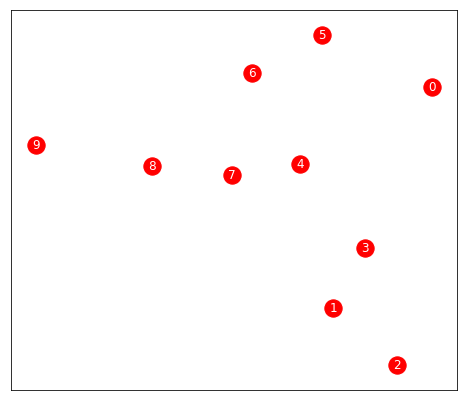

In [30]:
drawEmptyGraph(nx_graph, nx_layout, nx_labels)

### Observe Set of Cascades

node	 time
----	 ----
   0	 0.00
   5	 2.16
   6	 4.24
   7	 4.37
   8	 4.87
   9	 5.90


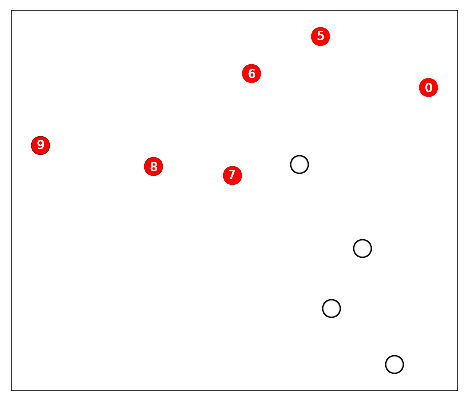

In [31]:
drawNetworkProp(nx_graph, nx_layout, nx_labels, sampleCascade(alpha, 10), 10)

### Infer Network Structure

/Users/brianallen131/miniconda3/envs/tensorflow/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


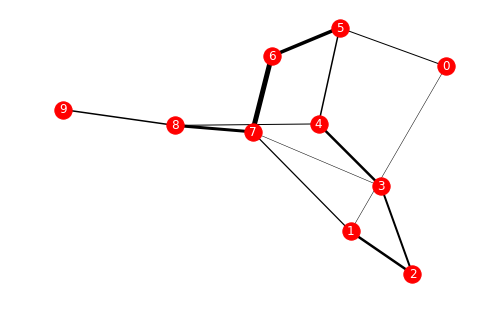

In [32]:
drawWeightedGraph(nx_graph, nx_layout, nx_weights, nx_labels)

# Models

## Model 1 

### Transmission Parameters

Transmission parameters, $\alpha_{ij}$ are defined for each pair of nodes as the positive transmission or infection rate from node $i$ to node $j$. When modeled as parameters to an Exponential distribution, the resulting set of observations $\tau$ are interarrival times of infections from node $i$ to $j$. Each $\alpha_{ij}$ must therefore be strictly positive.

As an extension to current work on this model, we incorporate an Exponential prior on each $\alpha_{ij}$ to extend the model from a maximum likelihood estimation to a more generative structure.

### Cascade Likelihood

All work on inferring diffusion networks (Rodriguez et al [1]) defines a likelihood function over the cascades in hopes to estimate the maxmium likelihood of the transmission parameters between nodes. The work consistently defines an exponential diffusion model using the following log-likelihood.

$p(C=c) = \Pi_{t_i \leq T} \Pi_{t_m > T} S(T|t_i, \alpha_{i,m}) \cdot \Pi_{t_j > t_i} S(t_i|t_j, \alpha_{j,i}) \sum_{t_j < t_i} H(t_i| t_k, \alpha_{k,i})$

Although this is a complicated likelihood function, the probability can be calculated with a series of tensor operations. However, as will be clear later in the report, this likehlihood does not lend itself to a pure generative model and is therefore difficult to incorporate into Edward's framework. This is evident from the discussion in the parameter estimation section.

Further derivations and explanation about the cascade likelihood can be found in the paper [here](http://snap.stanford.edu/class/cs224w-readings/rodriguez11diffusion.pdf) 

### Cascade Seed

Each cascade must have a starting point. Since this is an input into the cascade generative process, we draw a random cascade seed $S$ from a categorical distribution assuming all seeds are equally likely.

### Generative Model

- For each pair of nodes $(i,j)$:
    - Draw $\alpha_{ij} \sim$ Exp$(1)$
- For each cascade:
     - For each pair of nodes $(i,j)$:
        - Draw infection times $\tau_{ij} \sim$ Exp$(\alpha_{ij})$
     - Draw cascade seed $S \sim $Cat$(\delta)$
     - Observe the shortest path $C \sim $Shortest Path$(\tau,S)$

### Graphical Model

<img src="illustrations/model_with_prior.png" alt="drawing" style="width:500px;"/>

### Parameter Estimation

Coding shortest path as a generative model was outside the scope of our work, since it is not clear this is a differentiable procedure. In order to work around generating shortest path cascades, we then used cascade likelihood as the likelihood of the entire cascade plate. Coding a new random variable class for the cascade proved to be difficult in the amount of time for this project, which limited the parameter estimation procedures to MAP estimation. However, once the random variable class is built, inference can be expanded to the suite of tools used for probabilistic machine learning (e.g. CAVI, BBVI, MCMC, etc.)

## Model 2 - Topics

### Cascade Topic Assignment

Each cascade draws a topic assignment $Z$ from $K$ topics, with a predefined categorical probabilities $\theta$. For this model, $Z$ is a one-hot encoded vector, however it is trivial to extend the model to incorporate cascades with a mixture of topics.

### Transmission Parameters

In model 2, the $\alpha$ parameter is broken into two new parameters, $\alpha_0$ and $\alpha_1$. For a given cascade, define $\alpha = $Relu$(\alpha_0+\alpha_1 \cdot Z)$, where $\alpha_0$ acts as a $NxN$ intercept and $\alpha_1$ is a $NxNxK$ tensor where $k^{th}$ $NxN$ slice is activated when $Z=k$. This $\alpha_1$ parameter captures the polarity the node has for the given topic. A high similarity between the nodes polarity and the topic assignment, the more likely transmission.

### Generative Model

- For each pair of nodes $(i,j)$:
    - Draw $\alpha_0 \sim$ Exp$(1)$
    - For each topic K:
        - Draw $\alpha_1 \sim$ Exp$(1)$
- For each cascade:
     - Draw topic assignment $Z \sim $ Cat$(\theta)$:
     - For each pair of nodes $(i,j)$:
        - Draw infection times $\tau_{ij} \sim$ Exp$($Relu$(\alpha_0+\alpha_1 \cdot Z)$$)$
     - Draw cascade seed $S \sim $Cat$(\delta)$
     - Observe the shortest path $C \sim $Shortest Path$(\tau,S)$

### Graphical Model

<img src="illustrations/model_with_polarity.png" alt="drawing" style="width:500px;"/>

# Data

## Generated Datasets < PLACEHOLDER >

For model 1, we generated cascade data for a preset graph. This provides us a list of cascades and a network to infer upon, as well as a ground truth set. For model 2, we generated cascade data for two topics from two sets of alpha parameters. The first set of alpha parameters for the ground truth of topic 1 network parameters and the second set for the ground truth of topic 2 network parameters.

In [15]:
# PLACEHOLDER #

# m1_generated_cascade = sampleCascade(alpha,10,200)
# m2_generated_topics, m2_generated_cascade = sampleCascade(alpha,10,200)

## Memetracker < PLACEHOLDER >

Memetracker data are predominantly used in estimating diffusion graphs, which captures how viral phrases propagate throughout the documents. The raw dataset includes a phrase, a phrase id, a related phrase cluster, the URL of a webpage and a timestamp. For our analysis, we included the top 200 webpages (to reduce the size of the dataset) and transformed the dataset, such that we assumed a phrase to be a cascade. Lastly, we normalized the timestamp to be seconds until the first phrase has been posted.

In order to extract topic information from the cascades, we performed string searches for common political words (e.g. "politics", "republican", democractics", etc.) and common sports words ("NFL", "football", "player", etc.) String matches categorized the topic as either politics-related or sports-related.

In [ ]:
p = Preprocessing("data/clust-qt08080902w3mfq5.txt")
p.preprocess_data(200)

# Model 1 Inference

The inference method used was MAP estimation, due to our difficulties with the random variable class within tensorflow. In particular, we employed the L-BFGS optimizer within tensorflow to model the transmission parameters.

In [16]:
# PLACEHOLDER - GENERATE DATA #

# Model 2 Inference


For model 2, we generated cascade data for two topics from two sets of alpha parameters. The first set of alpha parameters for the ground truth of topic 1 network parameters and the second set for the ground truth of topic 2 network parameters.

# Model 1 Criticism

## Generated Dataset < PLACEHOLDER >

## Memetracker

# Model 2 Criticism

In [ ]:
m1_gen_alpha_politics = np.array([[0, .1, 0, 0, 0, .2, 0, 0, 0, 0],
                              [0, 0, .5, 0, 0, 0, 0, .25, 0, 0],
                              [0, 0, 0, .4, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, .5, 0, 0, .1, 0, 0],
                              [0, 0, 0, 0, 0, .3, 0, 0, .2, 0],
                              [0, 0, 0, 0, 0, 0, .7, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, .6, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, .3],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)

m1_inf_alpha_politics = np.array([[0, .1, 0, 0, 0, .1, 0, 0, 0, 0],
                              [0, 0, .4, 0, 0, 0, 0, .35, 0, 0],
                              [0, 0, 0, .4, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, .1, 0, 0, .1, 0, 0],
                              [0, 0, 0, 0, 0, .7, 0, 0, .2, 0],
                              [0, 0, 0, 0, 0, 0, .7, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, .1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, .8],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)


m1_gen_alpha_sports = np.array([[0, .1, 0, 0, 0, .2, 0, 0, 0, 0],
                              [0, 0, .5, 0, 0, 0, 0, .25, 0, 0],
                              [0, 0, 0, .4, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, .5, 0, 0, .1, 0, 0],
                              [0, 0, 0, 0, 0, .3, 0, 0, .2, 0],
                              [0, 0, 0, 0, 0, 0, .7, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, .6, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, .3],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)

m1_inf_alpha_sports = np.array([[0, .1, 0, 0, 0, .1, 0, 0, 0, 0],
                              [0, 0, .4, 0, 0, 0, 0, .35, 0, 0],
                              [0, 0, 0, .4, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, .1, 0, 0, .1, 0, 0],
                              [0, 0, 0, 0, 0, .7, 0, 0, .2, 0],
                              [0, 0, 0, 0, 0, 0, .7, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, .1, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, .8],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)

# Issues with Edward

## What we tried in Edward

## Non-Differentiability of Shortest Path

As mentioned in the model section, our struggle with Edward is concentrated in defining the shortest path operation on the $\tau$ transmission times. Since this is operation is non-differentiable, this is a non-trivial problem for performing inference. There is some work today about estimating shortest path using a recurrent neural network, however this is left for future work.

## Issues with Random Variable Class

As mentioned in the model 1 - parameter estimation section, we transitioned from working with generating a shortest path to evaluating the log probability of the cascade as part of the probabilistic model. Within Tensorflow and Edward, we can define a new random variable class that requires defining the log probability and sampling distribution. This proved to be time-consuming and difficult to debug. In order to get results, we stopped working with Edward's random variable class and built the algorithm by manually defining the log probability in tensorflow.


# Future Work

## Modeling

- Adding a Dirichlet prior to the topic draws, which allow for different probabilities of topic assignments
- Adding a Dirichlet prior to the seed draws, which allow for different probabilities of seed assignments 
- Allowing for mixture topic assignments

## Inference

- Build out the Cascade random variable in Edward
- Explore ways to incorporate differentiable shortest path (e.g. RNN)

## Criticism

- Separate the cascades into a train and validation set and compare metrics
- Toggle hyperparameters to ensure inferred network diameter aligns with reality

# References

[1] Rodriguez, M. G., Balduzzi, D., & Schölkopf, B. (2011). Uncovering the temporal dynamics of diffusion networks. arXiv preprint arXiv:1105.0697.

[2] Kempe, D., Kleinberg, J., & Tardos, É. (2003, August). Maximizing the spread of influence through a social network. In Proceedings of the ninth ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 137-146). ACM.

[3] Amini, Hamed, and Marc Lelarge. "The diameter of weighted random graphs." The Annals of Applied Probability 25.3 (2015): 1686-1727.


# GRAVEYARD

# Load Modules

Requirements can be found in the requirements.txt (ADD LINK!)file

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation
import networkx as nx

In [ ]:
from edward.models import Beta, Gamma, Exponential
import edward as ed
import tensorflow as tf

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from hdiffnet.preprocessing import Preprocessing
from hdiffnet.hdiffnet import ProbabilityModel
from hdiffnet.cascade_generator import GenerativeModel
from hdiffnet.utils import * 

# Data Processing

The raw memetracker dataset includes a phrase, a phrase id, a related phrase cluster, the URL of a webpage and a timestamp. For our analysis, we included the top 200 webpages (to reduce the size of the dataset) and transformed the dataset, such that we assumed a phrase to be a cascade and normalized the timestamp to be seconds until the first phrase has been posted. 

In [ ]:
# Load the data and transform it
p = Preprocessing("data/clust-qt08080902w3mfq5.txt")
p.preprocess_data(200)

In [ ]:
#show the data
p.data.head()

In [ ]:
# examples of news pages in the top 200 list. 
list(p.labels.keys())[:10]

In [ ]:
r = transform_full_to_sparse(p.data)

In [ ]:
r[0][:15]

# Model 1 Inference

In [ ]:
sess = ed.get_session()

In [ ]:
# Using the generative process, to generate a dataset
alpha = np.array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float32)

In [ ]:
gm = GenerativeModel(alpha, 10)
x = gm.build_cascade_series([1,2,3,0,6,0,0,0,0])

In [ ]:
# Generate two graphs with different priors
alpha = Gamma(tf.ones((10,10)),tf.ones((10,10)))
a1 = sess.run(alpha)

alpha = Gamma(tf.ones((10,10))*2,tf.ones((10,10))*10)
a2 = sess.run(alpha)

# Model 1 Criticism

In [ ]:
# visualize the networks with different priors
nx_graph, nx_layout, nx_weights, nx_labels = buildGraph(a1)
drawWeightedGraph(nx_graph, nx_layout, nx_weights, nx_labels)

In [ ]:
nx_graph, nx_layout, nx_weights, nx_labels = buildGraph(a2)
drawWeightedGraph(nx_graph, nx_layout, nx_weights, nx_labels)

TO ADD: How do we pick the Gamma parameters, from research about random graphs and social networks! 

### Implementing the prior probability in TF 

As our implementation with edward did not return viable result, we were implementing a log-prior probability in tensorflow to use BFGS to obtain a MAP estimate. As the log-prior is convex, this approach should yield a good estimate, even if Variational inference methods, may have resulted in better estimates. (REMARK Discuss this! Is it true?)






In [ ]:
# Feed the data into a tensorflow log-prior model.
max_T = p.data.hours_till_start.max()
numNodes = 199
model = ProbabilityModel(r[:400], numNodes, T = max_T)

# Inference

### Using edward Inference

Our probability model does uses a "dynamic graph", i.e. the computational graph changes in a non-trivial way, dependent on the cascade to improve computational complexity. This structure makes is difficult to transfer the generative process into a format edward can deal with. However, we tried the following approaches: 

* Create a customized random variable 
* Create an (not efficient) generative process in tensorflow, that should be differentiable

Both approaches, did not yield the results we were hoping. While we were unableo to get the customized random variable to work (due to a lack of edward documentations and ressources), we got the edward inference function to work for our second approach. However, when using our simulated dataset, our estimated seemed random and not related to our data input. Again, we abandoned this approach after we could not find much help in the edward documentation. 

### Using BFGS to obtain MAP estimates

We were using the Scipy BFGS optimizer to obtain our MAP results. 

In [ ]:
%time a3 = model.map_estimate_BFGS(max_iter=1000)

Runtimes depending on number of cascades <br> 
10: 0:26 min <br> 
20: 1:24 min <br> 
30: 1:28 min <br> 
50: 2:55 min <br> 
100: 6:55 min <br> 
200: 10:23 min <br> 
400: 20:27 min


In [ ]:
a3.round(3)[-6:,:]

# Criticism

Questions: 
* Does the Prior help? => does the generative process result in more realistic networks? Does the prior add real world information? 


It is not trivial to test the results of our inference model, as a specific cascade if very unlikely to occur and the resulting prediction problem has a very high dimensionality. That's why we used the following ways to see, whether our model describes the reality in a proper way: 

1. Compare cascade predictions with a heldout dataset
2. Compare our influence graph with the number of links between the website (a proxy for interconnectedness of websited) 
3. Visualize our influence graph to understand relationships 



### Predictions

Use the generative model to make predictions of the cascades given the seed set of the held out set. 

Compare the cascade times.

In [ ]:
test_set = r[-50:]
seeds = get_seed_set(test_set)
times = get_max_times(test_set)
test_set = convert_to_matrix(test_set, numNodes, times)

In [ ]:
# generate cascades according to the seed set
gm = GenerativeModel(a3.T, numNodes)
test_cascades = gm.build_cascade_series(seeds, times)


In [ ]:
# generate a benchmark cascade according to the seed set
alpha = Gamma(tf.ones((numNodes,numNodes)),tf.ones((numNodes,numNodes)))
a4 = sess.run(alpha)

gm = GenerativeModel(a4, numNodes)
benchmark_cascades = gm.build_cascade_series(seeds, times)

We are using several metrics to understand whether our model can predict future cascades: 

* squared loss (how good is the model to predict infection times) 
    * Mean squared error
    * Mean absolute error
* Rank coefficient (how good is the model in predicting the sequence of infected nodes) 
    * Kendall rank correlation coefficient
* Hit rate (how many nodes of a real cascade, does the prediction include)
    * Precision
    * Recall


In [ ]:
evaluate(test_set, test_cascades, benchmark_cascades, times)

### Compare to "influence approximations" 


Another way to test out model, would be to compare our inferred networks, with proxies of influence, s.a. the number of links one website has to another. While this data is available, we did not further pursue this approach, for two reasons: 
* the raw memetracker data with the urls is very large and it would have taken quite some effort to retrieve the link data
* we did not have enough time to do this as we spent most time on figuring our edward


### Visualizing MAP Estimate Results 

In [ ]:
nx_graph, nx_layout, nx_weights, nx_labels = buildGraph(a3.round(3))
drawWeightedGraph(nx_graph, nx_layout, nx_weights, nx_labels)

# Future Work 

Due to the limitation of time, we could not focus on these things, but as a next step we would improve the following things: 

* scalability: 

In [ ]:
p.data.node_id.nunique()